In [9]:
import tensorflow as tf
from scipy.signal import butter, lfilter, freqz
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import SGD, Adam
from google.colab import files
from sklearn.preprocessing import LabelEncoder

# display results to 3 decimal points, not in scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
uploaded = files.upload()

Saving SensorData_Acc_0.csv to SensorData_Acc_0.csv
Saving SensorData_Grav_0.csv to SensorData_Grav_0.csv
Saving SensorData_Gyr_0.csv to SensorData_Gyr_0.csv
Saving SensorData_LinAcc_0.csv to SensorData_LinAcc_0.csv
Saving SensorData_Mag_0.csv to SensorData_Mag_0.csv
Saving SensorData_Rot_0.csv to SensorData_Rot_0.csv


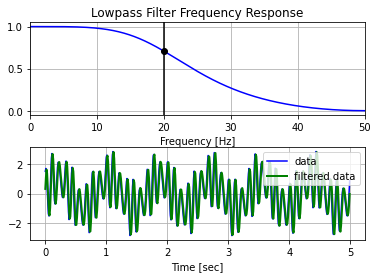

In [11]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 2
fs = 100.0       
cutoff = 20

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Creating the data for filteration
T = 5.0         # value taken in seconds
n = int(T * fs) # indicates total samples
t = np.linspace(0, T, n, endpoint=False)

data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filtering and plotting
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

# Data Pre-processing
Abbiamo pre-processato i dati andando ad eliminare i primi 2 secondi di dati in quanto abbiamo ritenuto non fossero direttamente collegati all'attivitá di estrazione o riposizionamento del telefono dalla tasca. 
Abbiamo inoltre sostituito la label con un formato numerico, piú adatto alla rete neurale rispetto alla stringa, formato piú human-readable.

In [29]:
accelerometer = pd.read_csv("SensorData_Acc_0.csv")
gyroscope = pd.read_csv("SensorData_Gyr_0.csv")
rotation = pd.read_csv("SensorData_Rot_0.csv")
gravity = pd.read_csv("SensorData_Grav_0.csv")
linearAcceleration = pd.read_csv("SensorData_LinAcc_0.csv")
magnetic = pd.read_csv("SensorData_Mag_0.csv")

del accelerometer["Unnamed: 5"]
del gyroscope["Unnamed: 5"]
del rotation["Unnamed: 5"]
del gravity["Unnamed: 5"]
del linearAcceleration["Unnamed: 5"]
del magnetic["Unnamed: 5"]

accelerometer.columns = ["acceleration-x", "acceleration-y", "acceleration-z", "timestamp", "label"]
accelerometer.index = accelerometer["timestamp"]

gyroscope.columns = ["gyroscope-x", "gyroscope-y", "gyroscope-z", "timestamp", "label"]
gyroscope.index = gyroscope["timestamp"]

gravity.columns = ["gravity-x", "gravity-y", "gravity-z", "timestamp", "label"]
gravity.index = gravity["timestamp"]

rotation.columns = ["rotation-x", "rotation-y", "rotation-z", "timestamp", "label"]
rotation.index = rotation["timestamp"]

magnetic.columns = ["magnetic-x", "magnetic-y", "magnetic-z", "timestamp", "label"]
magnetic.index = magnetic["timestamp"]

linearAcceleration.columns = ["linearAcceleration-x", "linearAcceleration-y", "linearAcceleration-z", "timestamp", "label"]
linearAcceleration.index = linearAcceleration["timestamp"]

del accelerometer["timestamp"]
del gyroscope["timestamp"]
del gyroscope["label"]
del gravity["timestamp"]
del gravity["label"]
del linearAcceleration["timestamp"]
del linearAcceleration["label"]
del rotation["timestamp"]
del rotation["label"]
del magnetic["timestamp"]
del magnetic["label"]


for column in accelerometer.columns:
  if column != "label" and column != "timestamp":
    y = butter_lowpass_filter(accelerometer[column], cutoff, fs, order)
    accelerometer[column] = y

for column in gyroscope.columns:
  if column != "label" and column != "timestamp":
    y = butter_lowpass_filter(gyroscope[column], cutoff, fs, order)
    gyroscope[column] = y

for column in gravity.columns:
  if column != "label" and column != "timestamp":
    y = butter_lowpass_filter(gravity[column], cutoff, fs, order)
    gravity[column] = y

for column in rotation.columns:
  if column != "label" and column != "timestamp":
    y = butter_lowpass_filter(rotation[column], cutoff, fs, order)
    rotation[column] = y

for column in magnetic.columns:
  if column != "label" and column != "timestamp":
    y = butter_lowpass_filter(magnetic[column], cutoff, fs, order)
    magnetic[column] = y

for column in linearAcceleration.columns:
  if column != "label" and column != "timestamp":
    y = butter_lowpass_filter(linearAcceleration[column], cutoff, fs, order)
    linearAcceleration[column] = y

merged = pd.merge(accelerometer, gyroscope, left_index=True, right_index=True)
merged = pd.merge(merged, linearAcceleration, left_index=True, right_index=True)
merged = pd.merge(merged, gravity, left_index=True, right_index=True)
merged = pd.merge(merged, magnetic, left_index=True, right_index=True)
merged = pd.merge(merged, rotation, left_index=True, right_index=True)

merged.to_csv("merged.csv")

# 50 hz sampling rate, 600 sample/seconds, discard first two seconds of data
N = 1000 
merged = merged.iloc[N: , :]
 
# Removing last n rows
merged = merged.iloc[:-N]

print(f"OTHER values {len(merged[(merged['label']=='OTHER')])}\n")
print(f"PICKUP values {len(merged[(merged['label']=='PICKUP')])}\n")

print(f"OTHER values are { (len(merged[(merged['label']=='OTHER')]) / len(merged)) * 100}% of the data\n")
print(f"PICKUP values are { (len(merged[(merged['label']=='PICKUP')]) / len(merged)) * 100}% of the data\n")

print(merged.shape)

encoder = LabelEncoder()
encoder.fit(merged["label"])
encoded_Y = encoder.transform(merged["label"])

merged["label"] = encoded_Y
print(merged)

training_data, testing_data = train_test_split(merged, test_size=0.1, random_state=25)

training_labels = training_data["label"]
del training_data["label"]

testing_labels = testing_data["label"]
del testing_data["label"]

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

print(f"Training shape: {training_data.shape}")

training_data = np.asarray(training_data).astype('float32')
training_labels = np.asarray(training_labels).astype('float32')
testing_data = np.asarray(testing_data).astype('float32')
testing_labels = np.asarray(testing_labels).astype('float32')

OTHER values 47460

PICKUP values 45257

OTHER values are 51.18802377126094% of the data

PICKUP values are 48.81197622873907% of the data

(92717, 19)
                 acceleration-x  acceleration-y  acceleration-z  label  \
timestamp                                                                
175810837279649          -2.063          -0.073          10.036      0   
175810847016940          -2.838          -0.459          10.224      0   
175810857016940          -1.994          -0.361          10.600      0   
175810869048857          -0.462          -0.282          10.256      0   
175810883241649           0.816          -0.174          10.065      0   
...                         ...             ...             ...    ...   
177052423269657           0.773           5.033           8.912      1   
177052434590657           0.436           4.595           8.758      1   
177052445174074           0.191           4.371           8.457      1   
177052450681866           0.177   

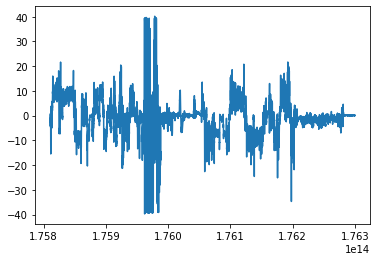

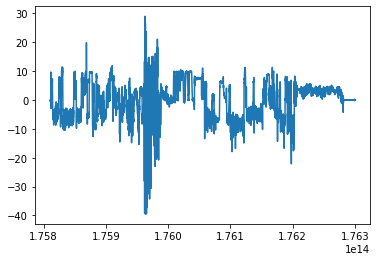

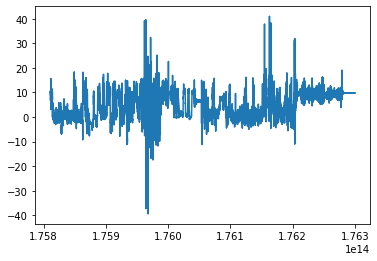

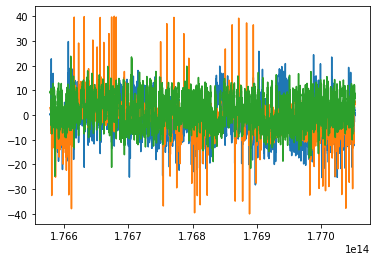

'\nplt.plot(merged[(merged[\'label\']==\'OTHER\')].index, merged[(merged[\'label\']==\'OTHER\')]["gravity-x"])\nplt.plot(merged[(merged[\'label\']==\'OTHER\')].index, merged[(merged[\'label\']==\'OTHER\')]["gravity-y"])\nplt.plot(merged[(merged[\'label\']==\'OTHER\')].index, merged[(merged[\'label\']==\'OTHER\')]["gravity-z"])\n\nplt.show()\n\nplt.plot(merged[(merged[\'label\']==\'PICKUP\')].index, merged[(merged[\'label\']==\'PICKUP\')]["gravity-x"])\nplt.plot(merged[(merged[\'label\']==\'PICKUP\')].index, merged[(merged[\'label\']==\'PICKUP\')]["gravity-y"])\nplt.plot(merged[(merged[\'label\']==\'PICKUP\')].index, merged[(merged[\'label\']==\'PICKUP\')]["gravity-z"])\n\nplt.show()\n\nplt.plot(merged[(merged[\'label\']==\'OTHER\')].index, merged[(merged[\'label\']==\'OTHER\')]["linearAcceleration-x"])\nplt.plot(merged[(merged[\'label\']==\'OTHER\')].index, merged[(merged[\'label\']==\'OTHER\')]["linearAcceleration-y"])\nplt.plot(merged[(merged[\'label\']==\'OTHER\')].index, merged[(me

In [33]:
plt.plot(merged[(merged['label']==0)].index, merged[(merged['label']==0)]["acceleration-x"])
plt.show()

plt.plot(merged[(merged['label']==0)].index, merged[(merged['label']==0)]["acceleration-y"])
plt.show()

plt.plot(merged[(merged['label']==0)].index, merged[(merged['label']==0)]["acceleration-z"])
plt.show()


plt.plot(merged[(merged['label']==1)].index, merged[(merged['label']==1)]["acceleration-x"])
plt.plot(merged[(merged['label']==1)].index, merged[(merged['label']==1)]["acceleration-y"])
plt.plot(merged[(merged['label']==1)].index, merged[(merged['label']==1)]["acceleration-z"])

plt.show()
"""
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["gravity-x"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["gravity-y"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["gravity-z"])

plt.show()

plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["gravity-x"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["gravity-y"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["gravity-z"])

plt.show()

plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["linearAcceleration-x"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["linearAcceleration-y"])
plt.plot(merged[(merged['label']=='OTHER')].index, merged[(merged['label']=='OTHER')]["linearAcceleration-z"])

plt.show()

plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["linearAcceleration-x"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["linearAcceleration-y"])
plt.plot(merged[(merged['label']=='PICKUP')].index, merged[(merged['label']=='PICKUP')]["linearAcceleration-z"])

plt.show()
"""

# Costruzione modello
Abbiamo quindi costruito un CNN utilizzando il modulo Tensorflow con diversi livelli.


In [37]:
model = models.Sequential()

model.add(layers.Flatten())
model.add(layers.Dense(1000, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(500, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
history = model.fit(training_data, training_labels, epochs=50, batch_size=4096, validation_split=0.1)
model.save(".")

Epoch 1/50
19/19 [==============================] - 10s 413ms/step - loss: 0.6721 - accuracy: 0.6192 - val_loss: 0.7379 - val_accuracy: 0.6273
Epoch 2/50
19/19 [==============================] - 6s 320ms/step - loss: 0.5578 - accuracy: 0.7085 - val_loss: 0.7125 - val_accuracy: 0.6600
Epoch 3/50
19/19 [==============================] - 6s 321ms/step - loss: 0.5105 - accuracy: 0.7463 - val_loss: 0.6070 - val_accuracy: 0.6987
Epoch 4/50
19/19 [==============================] - 6s 325ms/step - loss: 0.4824 - accuracy: 0.7685 - val_loss: 0.5335 - val_accuracy: 0.7295
Epoch 5/50
19/19 [==============================] - 6s 327ms/step - loss: 0.4600 - accuracy: 0.7832 - val_loss: 0.4811 - val_accuracy: 0.7843
Epoch 6/50
19/19 [==============================] - 6s 326ms/step - loss: 0.4379 - accuracy: 0.8003 - val_loss: 0.4426 - val_accuracy: 0.7904
Epoch 7/50
19/19 [==============================] - 6s 318ms/step - loss: 0.4142 - accuracy: 0.8150 - val_loss: 0.4118 - val_accuracy: 0.8186
Epoch

# Model evaluation
Metriche per la valutazione del modello e della capacità predittiva

290/290 - 1s - loss: 0.0356 - accuracy: 0.9896 - 667ms/epoch - 2ms/step


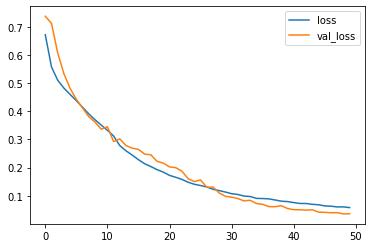

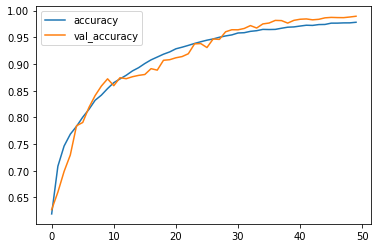

In [39]:
test_loss, test_acc = model.evaluate(testing_data,  testing_labels, verbose=2)

metrics_df = pd.DataFrame(history.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();

In [40]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(".") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('pickupClassifier.tflite', 'wb') as f:
  f.write(tflite_model)